In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import sampler
from torch.utils.data import DataLoader

import torchvision.datasets as dset
import torchvision.transforms as T

import timeit

import models
import solver
import views

In [3]:
dtype = torch.FloatTensor
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor

print_every = 100

def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
    
    
def show_solver_training(solver):
    views.show_traning(solver.loss_history, solver.train_acc_history, solver.val_acc_history)

    
def show_mean_and_std_hist(parameters):
    paras = [w.data.cpu().numpy() for w in parameters]
    views.plot_mean_std_hist(paras)

    
def show_conv_layer_weights(conv_weights):
    conv_weights = conv_weights.data.cpu().numpy()
    conv_weights = conv_weights.transpose(0, 2, 3, 1)
    views.show_conv_weights(conv_weights)

    
def compare_solvers_tranings(solvers_with_labels):
    loss_train_val_acc_with_labels = {}
    for label, solver in solvers_with_labels.items():
        loss_train_val_acc_with_labels[label] = (solver.loss_history, solver.train_acc_history, solver.val_acc_history)
    
    views.compare_trainings(loss_train_val_acc_with_labels)


In [4]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset.
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from"""
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start
        
    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))
    
    def __len__(self):
        return self.num_samples
    
NUM_TRAIN = 49000
NUM_VAL = 1000

NUM_TRAIN_SMALL = 64

cifar10_train_small = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
loader_train_small = DataLoader(cifar10_train_small, batch_size=64, sampler=ChunkSampler(NUM_TRAIN_SMALL, 0))

cifar10_train = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
loader_train = DataLoader(cifar10_train, batch_size=64, sampler=ChunkSampler(NUM_TRAIN, 0))

cifar10_val = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
# cifar10_val = cifar10_train # can do this?
loader_val = DataLoader(cifar10_val, batch_size=64, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

cifar10_test = dset.CIFAR10('../cs231n/datasets/', train=False, download=True, transform=T.ToTensor())
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# 1. Train base net

In [7]:
torch.cuda.random.manual_seed(12345)

#
base_model = models.BaseNet().type(dtype)
base_loss_fn = nn.CrossEntropyLoss().type(dtype)

lr = 1e-3
reg = 1e-6
step_size = 10
gamma = 0.2
num_epochs = 10

base_optimizer = optim.SGD(base_model.parameters(), lr=lr, momentum=0.9, weight_decay=reg)
base_lr_scheduler = lr_scheduler.StepLR(base_optimizer, step_size=step_size, gamma=gamma)

base_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                          model=base_model,
                                          loss_fn=base_loss_fn,
                                          optimizer=base_optimizer,
                                          scheduler=base_lr_scheduler,
                                          dtype=dtype,
                                          num_epochs=num_epochs,
                                          verbose=True
                                         )

base_solver.train()

t = 0, loss = 2.2971
t = 100, loss = 2.2689
t = 200, loss = 2.0912
t = 300, loss = 2.1538
t = 400, loss = 2.0910
t = 500, loss = 1.9915
t = 600, loss = 2.0989
t = 700, loss = 1.8476
(Epoch 0 / 10) train acc: 0.367188; val acc: 0.348000
t = 0, loss = 1.8920
t = 100, loss = 1.8151
t = 200, loss = 1.6393
t = 300, loss = 1.8745
t = 400, loss = 1.8134
t = 500, loss = 1.7490
t = 600, loss = 1.8578
t = 700, loss = 1.6022
(Epoch 1 / 10) train acc: 0.428711; val acc: 0.418000
t = 0, loss = 1.6417
t = 100, loss = 1.6389
t = 200, loss = 1.4131
t = 300, loss = 1.6733
t = 400, loss = 1.5826
t = 500, loss = 1.6099
t = 600, loss = 1.7022
t = 700, loss = 1.4854
(Epoch 2 / 10) train acc: 0.474609; val acc: 0.480000
t = 0, loss = 1.4926
t = 100, loss = 1.5534
t = 200, loss = 1.2647
t = 300, loss = 1.5878
t = 400, loss = 1.4106
t = 500, loss = 1.5559
t = 600, loss = 1.5675
t = 700, loss = 1.4200
(Epoch 3 / 10) train acc: 0.495117; val acc: 0.517000
t = 0, loss = 1.3822
t = 100, loss = 1.4870
t = 200, los

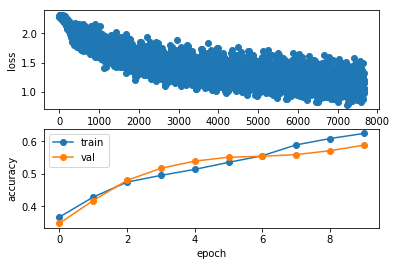

In [9]:
show_solver_training(base_solver)

## 1.1 minus different base net? without fc-bn

In [48]:
torch.cuda.random.manual_seed(12345)

#
base_model1 = models.BaseNet1().type(dtype)
base_loss_fn1 = nn.CrossEntropyLoss().type(dtype)

lr = 1e-3
reg = 1e-6
step_size = 10
gamma = 0.2
num_epochs = 10

base_optimizer1 = optim.SGD(base_model1.parameters(), lr=lr, momentum=0.9, weight_decay=reg)
base_lr_scheduler1 = lr_scheduler.StepLR(base_optimizer1, step_size=step_size, gamma=gamma)

base_solver1 = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                          model=base_model1,
                                          loss_fn=base_loss_fn1,
                                          optimizer=base_optimizer1,
                                          scheduler=base_lr_scheduler1,
                                          dtype=dtype,
                                          num_epochs=num_epochs,
                                          verbose=True
                                         )

base_solver1.train()

t = 0, loss = 2.2901
t = 100, loss = 2.2152
t = 200, loss = 1.9495
t = 300, loss = 2.0912
t = 400, loss = 2.0976
t = 500, loss = 1.9498
t = 600, loss = 2.0495
t = 700, loss = 1.7843
(Epoch 0 / 10) train acc: 0.373047; val acc: 0.389000
t = 0, loss = 1.8056
t = 100, loss = 1.7516
t = 200, loss = 1.6082
t = 300, loss = 1.8019
t = 400, loss = 1.7538
t = 500, loss = 1.7104
t = 600, loss = 1.7889
t = 700, loss = 1.5743
(Epoch 1 / 10) train acc: 0.445312; val acc: 0.461000
t = 0, loss = 1.6089
t = 100, loss = 1.5935
t = 200, loss = 1.3354
t = 300, loss = 1.5994
t = 400, loss = 1.4881
t = 500, loss = 1.6161
t = 600, loss = 1.6240
t = 700, loss = 1.4768
(Epoch 2 / 10) train acc: 0.475586; val acc: 0.501000
t = 0, loss = 1.4813
t = 100, loss = 1.5541
t = 200, loss = 1.2093
t = 300, loss = 1.5109
t = 400, loss = 1.3775
t = 500, loss = 1.6063
t = 600, loss = 1.5504
t = 700, loss = 1.4490
(Epoch 3 / 10) train acc: 0.495117; val acc: 0.519000
t = 0, loss = 1.4093
t = 100, loss = 1.5098
t = 200, los

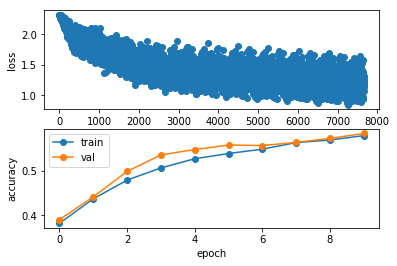

In [20]:
show_solver_training(base_solver1)

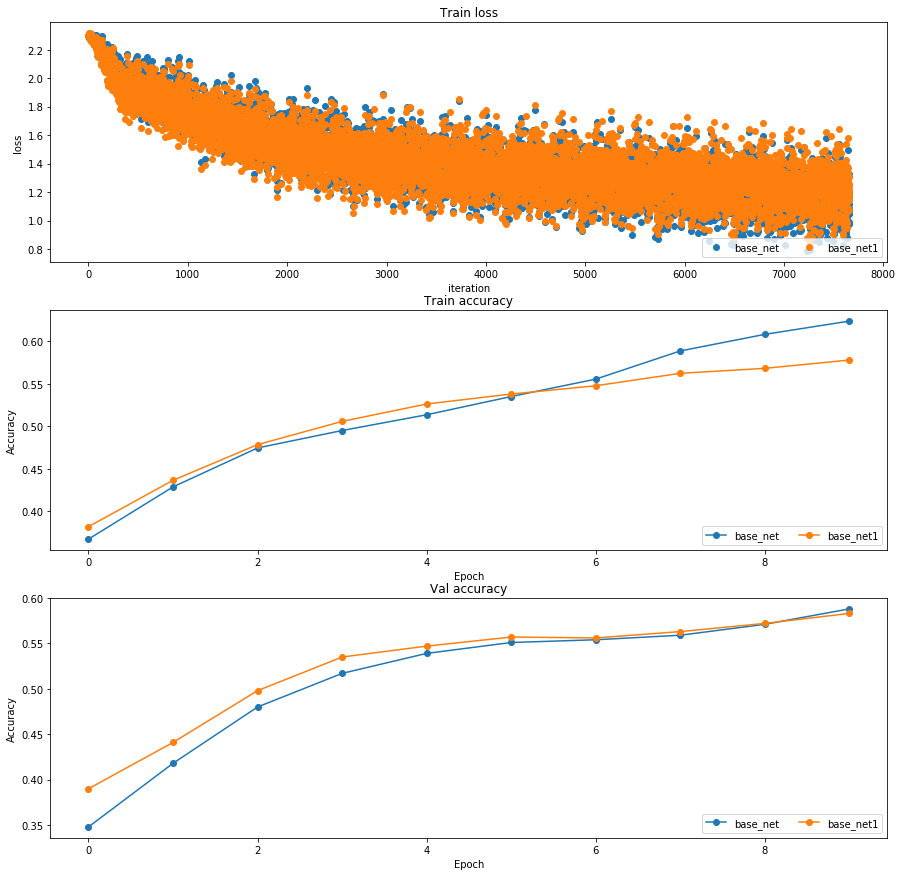

In [21]:
compare_solvers_tranings({'base_net': base_solver, 'base_net1': base_solver1})

# 2. with batch norm

In [77]:
torch.cuda.random.manual_seed(12345)

#
bn_model = models.BatchNormNet().type(dtype)
bn_loss_fn = nn.CrossEntropyLoss().type(dtype)

lr = 1e-3
reg = 1e-6
step_size = 10
gamma = 0.2
num_epochs = 20

bn_optimizer = optim.SGD(bn_model.parameters(), lr=lr, momentum=0.9, weight_decay=reg)
bn_lr_scheduler = lr_scheduler.StepLR(bn_optimizer, step_size=step_size, gamma=gamma)

bn_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                          model=bn_model,
                                          loss_fn=bn_loss_fn,
                                          optimizer=bn_optimizer,
                                          scheduler=bn_lr_scheduler,
                                          dtype=dtype,
                                          num_epochs=num_epochs,
                                          verbose=True
                                         )

bn_solver.train()

t = 0, loss = 2.3974
t = 100, loss = 1.5664
t = 200, loss = 1.2120
t = 300, loss = 1.5373
t = 400, loss = 1.3347
t = 500, loss = 1.5341
t = 600, loss = 1.4061
t = 700, loss = 1.3682
(Epoch 0 / 20) train acc: 0.551758; val acc: 0.520000
t = 0, loss = 1.3139
t = 100, loss = 1.2001
t = 200, loss = 0.8655
t = 300, loss = 1.2126
t = 400, loss = 1.0042
t = 500, loss = 1.2423
t = 600, loss = 1.1048
t = 700, loss = 1.1302
(Epoch 1 / 20) train acc: 0.638672; val acc: 0.586000
t = 0, loss = 1.1085
t = 100, loss = 1.0481
t = 200, loss = 0.7375
t = 300, loss = 1.0053
t = 400, loss = 0.8409
t = 500, loss = 1.0452
t = 600, loss = 0.8566
t = 700, loss = 0.9494
(Epoch 2 / 20) train acc: 0.682617; val acc: 0.608000
t = 0, loss = 0.8788
t = 100, loss = 0.8923
t = 200, loss = 0.5788
t = 300, loss = 0.8187
t = 400, loss = 0.7031
t = 500, loss = 0.9118
t = 600, loss = 0.7192
t = 700, loss = 0.8291
(Epoch 3 / 20) train acc: 0.740234; val acc: 0.628000
t = 0, loss = 0.6891
t = 100, loss = 0.7000
t = 200, los

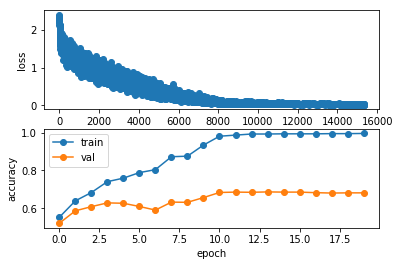

In [78]:
show_solver_training(bn_solver)

## compare with base net

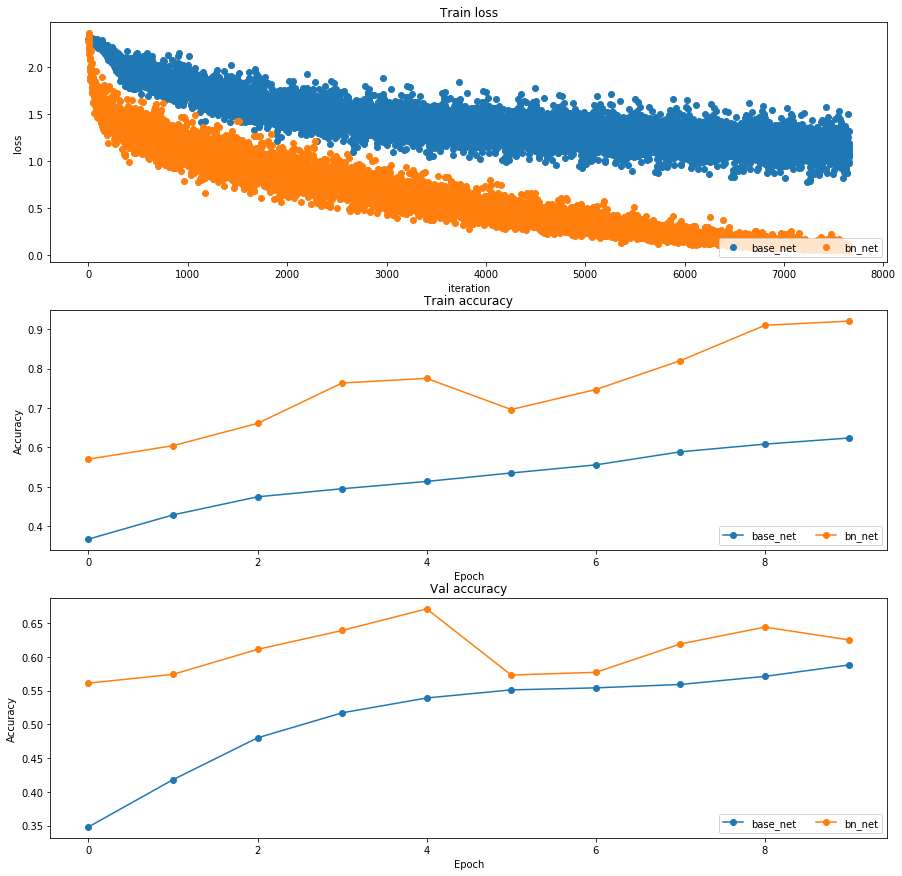

In [25]:
compare_solvers_tranings({"base_net": base_solver, "bn_net": bn_solver})

## 2.1 minus different bn net, but with huge difference in train_acc

In [74]:
torch.cuda.random.manual_seed(12345)

#
bn_model1 = models.BatchNormNet1().type(dtype)
bn_loss_fn1 = nn.CrossEntropyLoss().type(dtype)

lr = 1e-3
reg = 1e-6
step_size = 10
gamma = 0.2
num_epochs = 10

bn_optimizer1 = optim.SGD(bn_model1.parameters(), lr=lr, momentum=0.9, weight_decay=reg)
bn_lr_scheduler1 = lr_scheduler.StepLR(bn_optimizer1, step_size=step_size, gamma=gamma)

bn_solver1 = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                          model=bn_model1,
                                          loss_fn=bn_loss_fn1,
                                          optimizer=bn_optimizer1,
                                          scheduler=bn_lr_scheduler1,
                                          dtype=dtype,
                                          num_epochs=num_epochs,
                                          verbose=True
                                         )

bn_solver1.train()

t = 0, loss = 2.3342
t = 100, loss = 1.5457
t = 200, loss = 1.2125
t = 300, loss = 1.4444
t = 400, loss = 1.3104
t = 500, loss = 1.6294
t = 600, loss = 1.5127
t = 700, loss = 1.3338
(Epoch 0 / 10) train acc: 0.502930; val acc: 0.499000
t = 0, loss = 1.2877
t = 100, loss = 1.2239
t = 200, loss = 0.9008
t = 300, loss = 1.2128
t = 400, loss = 1.1055
t = 500, loss = 1.3459
t = 600, loss = 1.2526
t = 700, loss = 1.2003
(Epoch 1 / 10) train acc: 0.583008; val acc: 0.569000
t = 0, loss = 1.1104
t = 100, loss = 1.0742
t = 200, loss = 0.8290
t = 300, loss = 1.1968
t = 400, loss = 1.0165
t = 500, loss = 1.2953
t = 600, loss = 1.2008
t = 700, loss = 1.1439
(Epoch 2 / 10) train acc: 0.581055; val acc: 0.566000
t = 0, loss = 1.0021
t = 100, loss = 1.0047
t = 200, loss = 0.7642
t = 300, loss = 1.1244
t = 400, loss = 1.0001
t = 500, loss = 1.2408
t = 600, loss = 1.1563
t = 700, loss = 1.1246
(Epoch 3 / 10) train acc: 0.582031; val acc: 0.566000
t = 0, loss = 0.9474
t = 100, loss = 0.9624
t = 200, los

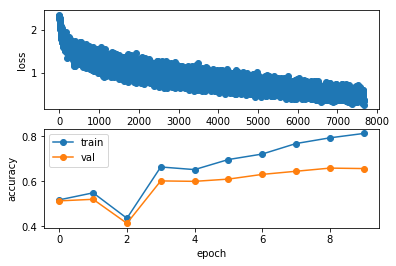

In [71]:
show_solver_training(bn_solver1)

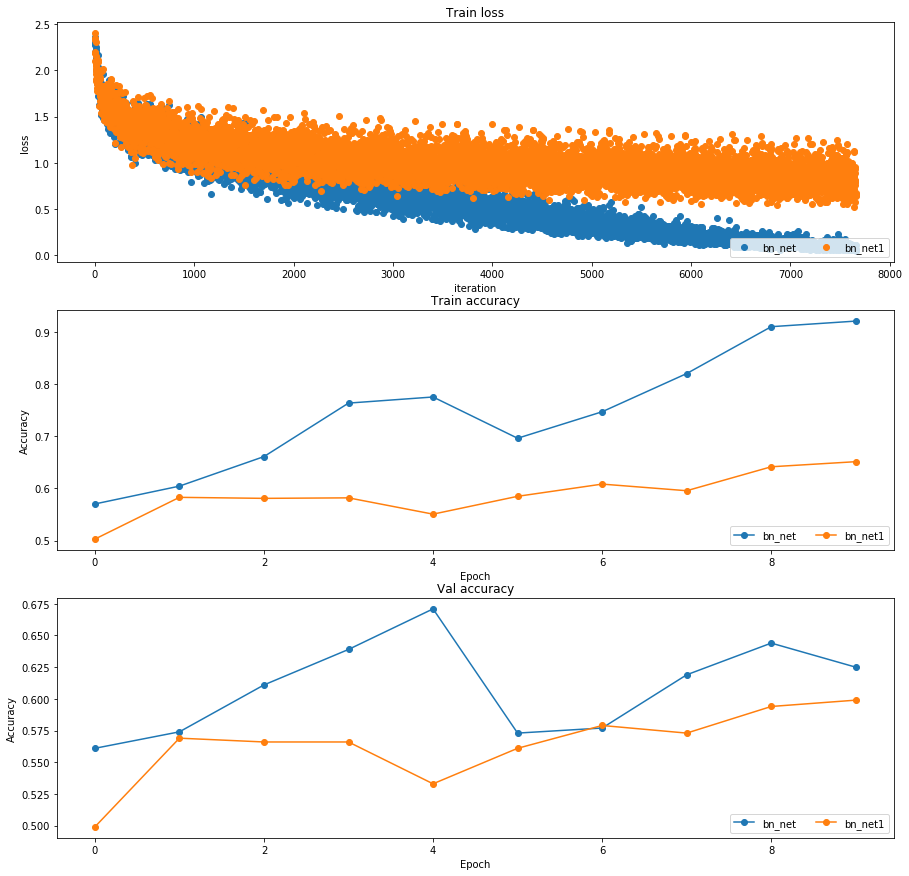

In [75]:
compare_solvers_tranings({'bn_net': bn_solver, 'bn_net1': bn_solver1})

# 3. Use small fiter

In [ ]:
torch.cuda.random.manual_seed(12345)

#
sf_model = models.SmallFilterNet().type(dtype)
sf_loss_fn = nn.CrossEntropyLoss().type(dtype)

lr = 1e-3
reg = 5e-2
step_size = 10
gamma = 0.2
num_epochs = 30

sf_optimizer = optim.SGD(sf_model.parameters(), lr=lr, momentum=0.9, weight_decay=reg)
sf_lr_scheduler = lr_scheduler.StepLR(sf_optimizer, step_size=step_size, gamma=gamma)

sf_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                          model=sf_model,
                                          loss_fn=sf_loss_fn,
                                          optimizer=sf_optimizer,
                                          scheduler=sf_lr_scheduler,
                                          dtype=dtype,
                                          num_epochs=num_epochs,
                                          verbose=True
                                         )

sf_solver.train()

t = 0, loss = 2.3758
t = 100, loss = 1.4854
t = 200, loss = 1.1539
t = 300, loss = 1.3014
t = 400, loss = 1.1015
t = 500, loss = 1.3822
t = 600, loss = 1.2506
t = 700, loss = 1.2303
(Epoch 0 / 30) train acc: 0.529297; val acc: 0.500000
t = 0, loss = 1.1584
t = 100, loss = 1.1146
t = 200, loss = 0.9123
t = 300, loss = 1.0884
t = 400, loss = 0.9325
t = 500, loss = 1.1494
t = 600, loss = 1.0575
t = 700, loss = 1.1054
(Epoch 1 / 30) train acc: 0.557617; val acc: 0.517000
t = 0, loss = 0.9657
t = 100, loss = 1.0086
t = 200, loss = 0.8061
t = 300, loss = 0.9811
t = 400, loss = 0.8977
t = 500, loss = 1.1056
t = 600, loss = 1.0144
t = 700, loss = 1.0813
(Epoch 2 / 30) train acc: 0.644531; val acc: 0.643000
t = 0, loss = 0.9493
t = 100, loss = 0.9470
t = 200, loss = 0.7711
t = 300, loss = 0.9628
t = 400, loss = 0.9196
t = 500, loss = 1.1055
t = 600, loss = 0.9892
t = 700, loss = 1.0634
(Epoch 3 / 30) train acc: 0.686523; val acc: 0.682000
t = 0, loss = 0.9933
t = 100, loss = 0.9369
t = 200, los

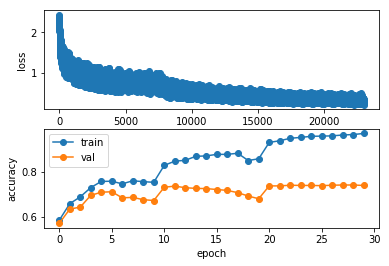

In [87]:
show_solver_training(sf_solver)

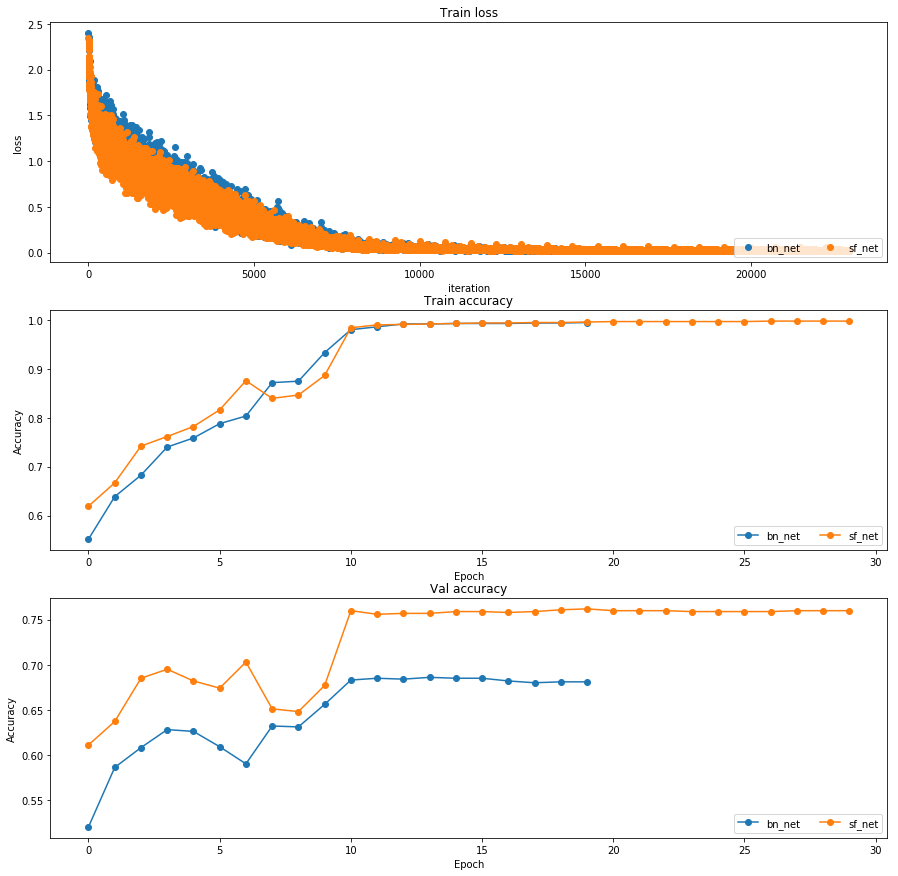

In [81]:
compare_solvers_tranings({'bn_net': bn_solver, 'sf_net': sf_solver})